# RNN

# 7.2 영화 리뷰 감정 분석

7.2.1 자연어 처리

In [1]:
# 모델 구현과 학습에 필요한 라이브러리 임포트하기

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets  # 자연어 다루기 때문에 torchvision이 아니라 torchtext 사용

In [2]:
# 모델 구현과 학습에 필요한 하이퍼파라미터 정의

BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cpu


In [28]:
# 데이터 로딩하기
print("데이터 로딩중...")
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True)
trainset, testset = datasets.IMDB.splits(TEXT, LABEL)
TEXT.build_vocab(trainset, min_freq=5)
LABEL.build_vocab(trainset)

# 학습용 데이터를 학습셋 80% 검증셋 20% 로 나누기
trainset, valset = trainset.split(split_ratio=0.8)
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False)


vocab_size = len(TEXT.vocab)
n_classes = 2


데이터 로딩중...


In [3]:
# IMDB 데이터셋 로딩하고 텐서로 변환하기
# 우선 텍스트 형태의 영화 리뷰들과 그에 해당하는 레이블을 텐서로 바꿔줄 때 필요한 설정을 정함
# 즉, torchtext.data의 Field 클래스를 사용하여 영화 리뷰에 대한 객체 TEXT, 레이블을 위한 객체 LABEL을 생성한다는 것

# sequential은 순차적인 데이터 셋인지를 명시하는 역할
# batch_first는 신경망에 입력되는 텐서의 첫 번째 차원값이 batch_size가 되도록 정해주는 역할
# lower은 텍스트 데이터 속 모든 영문 알파벳이 소문자가 되도록 처리하는 역할
TEXT = data.Field(sequential = True, batch_first = True, lower = True)  
LABEL = data.Field(sequential = False, batch_first = True)

# 그 다음으로는 datasets의 객체의 splits 함수를 이용해 모델에 입력되는 데이터셋을 만들어줌
# (IMDB 리뷰 데이터를 다운 받는 동시에 훈련 데이터와 테스트 데이터를 분할하고, 각각 trainset, testset에 저장)
trainset, testset = datasets.IMDB.splits(TEXT,LABEL)

# 리뷰 데이터가 저장되어 있는 text필드와 레이블이 저장되어 있는 label 필드가 존재
print ('trainset의 구성요소 출력: ', trainset.fields)
print ('testset의 구성요소 출력: ', testset.fields)

# 만들어진 데이터셋을 이용해 워드 임베딩에 필요한 단어 사전 만들기
# 사전이란 중복을 제거한 총 단어들의 집합 의미
TEXT.build_vocab(trainset, min_freq = 5)  # min_freq은 학습 데이터에서 최소 5번 이상 등장한 단어만 사전에 담겠다는 의미, 5번 이하는 unk토큰으로 대체됨
LABEL.build_vocab(trainset)

trainset의 구성요소 출력:  {'text': <torchtext.data.field.Field object at 0x00000220F38489A0>, 'label': <torchtext.data.field.Field object at 0x00000220F3848970>}
testset의 구성요소 출력:  {'text': <torchtext.data.field.Field object at 0x00000220F38489A0>, 'label': <torchtext.data.field.Field object at 0x00000220F3848970>}


In [4]:
# IMDB 데이터셋에선 따로 검증셋이 존재하지 않기 때문에 학습셋을 쪼개서 사용함
trainset,valset = trainset.split(split_ratio=0.8)   # 학습셋이 80%, 검증셋이 20%가 되도록 함

In [5]:
# 텍스트 형태의 데이터도 모든 학습 데이터를 한번에 처리하기보단 batch단위로 쪼개서 학습을 진행해야함
# trainset, valset, testset에서 반복할 때마다 배치를 생성해주는 반복자 만듦
# 이 반복자를 enumerate함수에 입력시켜 루프를 구현하면 루프 때마다 전체 데이터셋에서 배치 단위의 데이터가 생성됨    ?????무슨소리
# 토치 텍스트는 단어를 인덱스 번호로 대체하는 BucketIterator를 제공함
# 이제 train_iter, val_iter, test_iter에는 샘플과 레이블이 64개 단위 묶음으로 저장됨

train_iter, val_iter, test_iter = data.BucketIterator.splits((trainset,valset,testset), batch_size = BATCH_SIZE, shuffle = True,
                                                            repeat = False) 

In [30]:
# 64개씩 묶었을 때 총 배치의 개수가 몇 개가 되는지 출력
print('훈련 데이터의 미니 배치의 개수 : {}'.format(len(train_iter)))
print('테스트 데이터의 미니 배치의 개수 : {}'.format(len(test_iter)))
print('검증 데이터의 미니 배치의 개수 : {}'.format(len(val_iter)))

훈련 데이터의 미니 배치의 개수 : 57
테스트 데이터의 미니 배치의 개수 : 391
검증 데이터의 미니 배치의 개수 : 15


In [7]:
# 사전 속 단어들의 개수와 레이블 수를 정해주는 변수 생성
vocab_size = len(TEXT.vocab)   # 중복을 제거한 총 단어의 갯수 의미
n_classes = 2

In [29]:
# 학습셋, 검증셋, 테스트셋의 예제 갯수 출력
print("[학습셋]: %d [검증셋]: %d [테스트셋]: %d [단어수]: %d [클래스] %d" % (len(trainset),len(valset), len(testset), vocab_size, n_classes))

[학습셋]: 3647 [검증셋]: 912 [테스트셋]: 25000 [단어수]: 13402 [클래스] 2


7.2.2 RNN 모델 구현

In [31]:
class BasicGRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p = 0.2):
        super(BasicGRU,self).__init__()
        print("Building Basic GRU Model...")
        self.n_layers = n_layers  # n_layers는 은닉 벡터들의 층( 아주 복잡한 모델 아닌 이상 2로 정의하는게 보통 )
        
         # n_vocab은 전체 데이터셋의 모든 단어를 사전 형태로 나타냈을 때 그 사전에 등재된 단어 수
        # embed_dim은 임베딩된 단어 텐서가 지니는 차원 값
        self.embed = nn.Embedding(n_vocab, embed_dim) 
        
        # RNN통해 생성되는 은닉 벡터의 차원값과 드롭아웃을 정의
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout_p)
        
        # RNN 모델 정의
        # RNN은 입력이 길어지면 학습 도중 기울기가 너무 작아지거나 커져서 앞부분에 대한 정보를 담지 못할 수도 있음
        # 따라서 이러한 결함을 보완한 GRU 사용
        self.gru = nn.GRU(embed_dim, self.hidden_dim, num_layers = self.n_layers, batch_first = True)
        
        # GRU도 시계열 데이터 하나를 하나의 텐서로 압축 -> 문장 전체에 대한 맥락 담고 있음
        # 영화 리뷰가 긍정인지 부정인지 분류하기 위해서 압축된 텐서를 신경망에 통과시켜 클래스에 대한 예측을 출력하도록 함
        self.out = nn.Linear(self.hidden_dim, n_classes)
        
    def forward(self,x):
        x = self.embed(x)
        # 첫 번째 은닉 벡터
        h_0 = self._init_state(batch_size = x.size(0))  # 모든 특성값이 0인 벡터로 설정됨
        
        # x를 첫 번째 은닉 벡터 h_0과 함께 self.gru함수에 입력하면 은닉 벡터들이 시계열 배열 형태로 반환됨
        # 즉, self.gru(x,h_o)의 결과값은 (batch_size, 입력 x의 길이, hidden_dim)의 모양을 지닌 3차원 텐서
        x, _ = self.gru(x,h_0)  
        
        # 배치 내 모든 시계열 은닉 벡터들의 마지막 토큰들을 내포한 (batch_size,1,hidden_dim)모양의 텐서를 추출할 수 있음
        h_t = x[:,-1,:]  # 영화 리뷰 배열들을 압축한 은닉 벡터
        self.dropout(h_t)
        
        logit = self.out(h_t)
        return logit
        
    def _init_state(self,batch_size = 1):
        # parameters함수는 그 신경망 모듈의 가중치 정보를 반복자 형태로 반환
        # 이 반복자가 생성하는 원소들은 각각 실제 신경망의 가중치 텐서를 지닌 객체들
        weight = next(self.parameters()).data  # nn.GRU모듈의 첫 번째 가중치 텐서를 추출
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [32]:
# train(학습) 함수와 evaluate(평가) 함수 구현

# train
def train(model,optimizer,train_iter):
    model.train()
    for b,batch in enumerate(train_iter):  # 반복마다 배치 데이터 반환, 배치 내의 영화평 데이터와 그에 상응하는 레이블에 접근
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub(1)  # batch.label은 1이나 2의 값을 가지고 있어서 1씩 빼서 0 또는 1 값으로 만들어줌
        optimizer.zero_grad()
        logit = model(x)   # 예측값
        loss = F.cross_entropy(logit,y)
        loss.backward()
        optimizer.step()
        
# evaluate - 검증셋과 테스트셋의 성능 측정을 위한 함수
# 경사하강 과정을 건너뛰는 것을 빼고는 train함수와 거의 같음. but, 모델의 평가를 위해 데이터셋에 대한 loss값과 정확도의 평균을 반환함
def evaluate(model,val_iter):
    model.eval()
    corrects, total_loss = 0,0
    for batch in val_iter :
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE) 
        y.data.sub(1)  # batch.label은 1이나 2의 값을 가지고 있어서 1씩 빼서 0 또는 1 값으로 만들어줌
        logit = model(x)   # 예측값
        # loss값과 정확도를 구하기 위해 각 배치의 평균을 구하는게 아니라 데이터셋 전체의 합을 구함
        loss = F.cross_entropy(logit,y,reduction = 'sum')  # 오차의 합 구함
        total_loss +=loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum() # 모델의 맞힌 수
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [33]:
# 모델 객체 정의
model = BasicGRU(1, 256, vocab_size, 128, n_classes, 0.5).to(DEVICE) # 모델 내 은닉 벡터의 차원값 : 256, 임베딩된 토큰의 차원값 : 128 으로 임의로 설정
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # 최적화 알고리즘

Building Basic GRU Model...


In [34]:
# 학습 실행
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[이폭: %d] 검증 오차:%5.2f | 검증 정확도:%5.2f" % (e, val_loss, val_accuracy))
    
    # 최종 모델은 학습 오차가 아닌 검증 오차가 최소화된 모델을 원함
    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:  # best_val_loss가 아니거나 val_loss가 best_val_loss보다 작으면 수행
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

[이폭: 1] 검증 오차: 0.00 | 검증 정확도:100.00
[이폭: 2] 검증 오차: 0.00 | 검증 정확도:100.00
[이폭: 3] 검증 오차: 0.00 | 검증 정확도:100.00
[이폭: 4] 검증 오차: 0.00 | 검증 정확도:100.00
[이폭: 5] 검증 오차: 0.00 | 검증 정확도:100.00
[이폭: 6] 검증 오차: 0.00 | 검증 정확도:100.00
[이폭: 7] 검증 오차: 0.00 | 검증 정확도:100.00
[이폭: 8] 검증 오차: 0.00 | 검증 정확도:100.00
[이폭: 9] 검증 오차: 0.00 | 검증 정확도:100.00
[이폭: 10] 검증 오차: 0.00 | 검증 정확도:100.00


In [35]:
# 학습 마친 후 테스트 셋으로 모델의 성능을 시험
# 검증셋에서 가장 성능이 좋았던 모델을 불러와 테스트

model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_accuracy = evaluate(model,test_iter)
print('테스트 오차: %5.2f  |  테스트 정확도: %5.2f' % (test_loss, test_accuracy))

테스트 오차:  4.75  |  테스트 정확도: 50.00


# 7.3 Seq2Seq 기계 번역

7.3.4 Seq2Seq 모델 구현하기

In [36]:
# 구현에 필요한 라이브러리 임포트

import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

In [37]:
# 데이터셋 속에 총 몇 종류의 토큰이 있는지 정의
# 영문만 다룰 것이므로 영문을 숫자로 표현하는 방식인 아스키 코드로 임베딩을 대신할 것임
# 아스키 코드로는 총 256개의 글자를 표현할 수 있으므로 사전에 담을 수 있는 토큰의 수를 256으로 정의
vocab_size = 256

In [46]:
# 모델에 입력될 원문과 번역문을 아스키 코드의 배열로 정의하고 파이토치 텐서로 바꾸기

x_ = list(map(ord,"hello"))  # ord는 문자의 아스키 값을 돌려주는 함수
y_ = list(map(ord,"hola"))   # map은 함수와 반복 가능한 자료형을 입력받아서 그 자료형의 각 요소를 함수를 수행한 결과를 묶어서 돌려주는 함수
print("hello -> ", x_)
print("hola  -> ", y_)
x = torch.LongTensor(x_)     # 파이토치 텐서로 바꾸기
y = torch.LongTensor(y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [75]:
# 모델 클래스 정의

class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        # 원문과 번역문의 문자체계가 완전히 다르면 임베딩을 따로 만들어야하지만 이번 예제에서는 둘 다 아스키코드로 나타내서 하나만 만들어도됨
        self.embedding = nn.Embedding(vocab_size,hidden_size)   # hidden_size는 임베딩된 토큰의 차원값을 말함
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        # 디코더가 번역문의 다음 토큰을 예상해내는 작은 신경망을 하나 더 만들어줌
        self.project = nn.Linear(hidden_size, vocab_size)  # 왜 만드는건지 이해 못함
        
    def forward(self,inputs,targets):
        initial_state = self._init_state()  # 인코더의 첫 번째 은닉 벡터를 정의   (첫 번째 은닉 벡터가 뭔지 모르겠음)
        embedding = self.embedding(inputs).unsqueeze(1)  # 인코더에 입력되는 원문을 구성하는 모든 문자("hello")를 임베딩시킴
        
        # 원문을 인코더에 입력해서 문맥 벡터인 encoder_state를 만듦
        # 디코더가 번역문의 첫 번째 토큰을 예상하려면 인코더의 문맥 벡터와 문장 시작 토큰을 입력 데이터로 받아야함
        encoder_output, encoder_state = self.encoder(embedding, initial_state)  # output은 무엇?
        decoder_state = encoder_state  # 문맥 벡터를 디코더의 첫 번째 은닉 벡터 decoder_state로 지정함
        
        # 문장 시작 토큰은 실제로 문장에 나타나지는 않지만 디코더가 정상적으로 작동할 수 있게 넣은 토큰
        # 디코더에 문장의 시작을 알리기 위함이며 아스키 값으로 공백 문자를 뜻하는 0으로 설정함
        decoder_input = torch.LongTensor([0])   # 문장 시작 토큰
        
        outputs = []
        # 디코더는 문장 시작 토큰인 아스키 번호 0을 이용해 번역문 hola의 h 토큰을 예측했으면 다음 반복에서는 h토큰 이용해 o토큰 예측해야함
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            
            # 디코더 결과값은 다시 디코더 모델에 입력됨
            # 디코더 출력값이 신경망의 마지막 층인 소프트맥스 층을 거치면 번역문의 다음 예상 글자가 나옴
            projection = self.project(decoder_output)
            outputs.append(projection)   # 이 예상 결과를 outputs텐서에 저장해 오차를 계산할 때 사용할 것임
            
            # 디코더 학습 시 실제 번역문의 토큰을 디코더의 전 출력값 대신 입력으로 사용해 학습을 가속하는 방법
            decoder_input = torch.LongTensor([targets[i]])  # 티처 포싱
           
        outputs = torch.stack(outputs).squeeze()
        return outputs
        
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()    
        

In [76]:
seq2seq = Seq2Seq(vocab_size, 16)
criterion = nn.CrossEntropyLoss()    # 교차 크로스 엔트로피 오차 함수
optimizer = torch.optim.Adam(seq2seq.parameters(),lr=1e-3)   # 최적화 알고리즘

In [77]:
log = []
for i in range(1000):  # 1000번의 이폭을 거쳐 모델 학습
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 반복:0 오차: 5.758358001708984
['X', 'X', 'Î', 'Ø']

 반복:100 오차: 2.191209316253662
['o', 'o', 'a', 'a']

 반복:200 오차: 0.7097018957138062
['h', 'o', 'l', 'a']

 반복:300 오차: 0.355837881565094
['h', 'o', 'l', 'a']

 반복:400 오차: 0.23188045620918274
['h', 'o', 'l', 'a']

 반복:500 오차: 0.16872064769268036
['h', 'o', 'l', 'a']

 반복:600 오차: 0.13022974133491516
['h', 'o', 'l', 'a']

 반복:700 오차: 0.10436157882213593
['h', 'o', 'l', 'a']

 반복:800 오차: 0.08586667478084564
['h', 'o', 'l', 'a']

 반복:900 오차: 0.07206021249294281
['h', 'o', 'l', 'a']


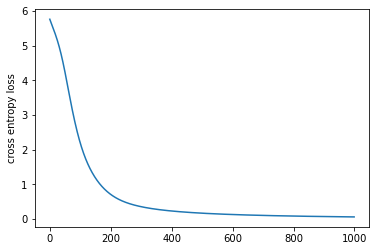

In [78]:
# 학습을 진행하면서 오차가 줄어드는 것을 시각화

plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()